# Setup

In [0]:
## update the latest seaborn (0.9.0) and prophet
!pip install seaborn==0.9.0
!pip install prophet

In [1]:
## setup our environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## date and timeseries forecasting tooling
import datetime
from fbprophet import Prophet

## machine learning/predictive analytics tools              # <-------- New imports!
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


## pandas print columns/rows option (100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## set the styling for seaborn (white)
sns.set_style("dark")

# Machine Learning Introduction 

![](https://i0.wp.com/dataaspirant.com/wp-content/uploads/2014/09/Classification-and-Regression-dataaspirant.png?resize=690%2C518)



---



Machine Learning / Predictive Analytics / Data Mining

- process of using data to build models and find patterns in the data


In the course to date, we have covered the tools and skills needed to:
- acquire data
- clean data
- sort/filter data (both rows and columns)
- get quick summaries of our data
- create aggregates of our data
- reshape our data
- merge datasets
- visualize our data

From here, the next step of analyzing data is to start to draw insights to make predictions to help with decision making, or find patterns in the data to help simplify operational goals (market segmentation, cluster customers, etc.)





---

![](https://www.mathworks.com/help/stats/machinelearning_supervisedunsupervised.png)



---

<br>


To view the difference between classification and regression:

![](https://cdn-images-1.medium.com/max/1600/0*WE3Sz--1NUEWBmUR.)



---

<br>

![](https://blogs.nvidia.com/wp-content/uploads/2018/07/Supervised_machine_learning_in_a_nutshell.svg_.png)







---



![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Scikit_learn_logo_small.svg/1200px-Scikit_learn_logo_small.svg.png)



---



We are going to cover KNN Classification, which uses a value `K` to set the n nearest-neighbors, and from there, take the most frequent value for our target as the prediction.

<img src="https://monosnap.com/image/oxafG5iNgWtqSAvLE8VFGVR6IVKt6O.png">



#### Terminology:

- `K`:  how many nearest neighbors to use to drive the consensus prediction
- `features`:  these are the variables that we use to drive the predictions
- `target, or y`:  the variable that we are trying to predict



---



![](http://seekvectorlogo.com/wp-content/uploads/2018/01/spotify-vector-logo-small.png)

We have been hired by Spotify to figure out if we can classify the `mode` of new songs hitting their music platform based on the musical properties of the track.  We can use K-Nearest Neighbors Classification to learn the target variable using the top 100 songs from last year.



<br>
<brr>



In [2]:
## load our dataset
url = "https://raw.githubusercontent.com/Btibert3/is834/master/datasets/top100-songs-2018.csv"
songs = pd.read_csv(url)
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
id                  100 non-null object
name                100 non-null object
artists             100 non-null object
danceability        66 non-null float64
energy              66 non-null float64
key                 100 non-null int64
loudness            100 non-null float64
mode                100 non-null int64
speechiness         100 non-null float64
acousticness        100 non-null float64
instrumentalness    5 non-null float64
liveness            69 non-null float64
valence             100 non-null float64
tempo               100 non-null float64
duration_ms         100 non-null int64
time_signature      100 non-null int64
dtypes: float64(9), int64(4), object(3)
memory usage: 12.6+ KB


In [3]:
## confirm we have missing values -- express as percentage
songs.isna().sum() / len(songs)

id                  0.00
name                0.00
artists             0.00
danceability        0.34
energy              0.34
key                 0.00
loudness            0.00
mode                0.00
speechiness         0.00
acousticness        0.00
instrumentalness    0.95
liveness            0.31
valence             0.00
tempo               0.00
duration_ms         0.00
time_signature      0.00
dtype: float64

Most machine learning techniques, especially when we write code, get angry when we:

- have missing values
- are data are not numeric in nature

In particular, scikit learn requires that our data are numeric and either represent numpy arrays or pandas dataframes.  We will see that in a moment.

For now, lets clean the data

In [4]:
# remove the column with majority nas
songs.drop(columns=["instrumentalness"], inplace=True)

In [5]:
# replace the other missing values with the mean from each column
dance_mean = songs.danceability.mean()
songs.danceability.fillna(dance_mean, inplace=True)
live_mean = songs.liveness.mean()
songs.liveness.fillna(live_mean, inplace=True)
energy_mean = songs.energy.mean()
songs.energy.fillna(energy_mean, inplace=True)



In [6]:
# confirm
songs.isna().sum()

id                0
name              0
artists           0
danceability      0
energy            0
key               0
loudness          0
mode              0
speechiness       0
acousticness      0
liveness          0
valence           0
tempo             0
duration_ms       0
time_signature    0
dtype: int64

In [7]:
# Because we are trying to predict a value, we need to think about the columns we want to use as features, and then the target
songs['mode'].value_counts()

1    59
0    41
Name: mode, dtype: int64

> We will use the mode column as our target variable, as its binary to keep things simple, also numeric, and relatively balanced

In [8]:
# list the columns
songs.columns

Index(['id', 'name', 'artists', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature'],
      dtype='object')

In [9]:
songs.head()

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo,duration_ms,time_signature
0,6DCZcSspjsKoFjzjrWoCd,God's Plan,Drake,0.754000,0.449000,7,-9.211,1,0.1090,0.0332,0.552000,0.357,77.169,198973,4
1,3ee8Jmje8o58CHK66QrVC,SAD!,XXXTENTACION,0.740000,0.613000,8,-4.880,1,0.1450,0.2580,0.123000,0.473,75.023,166606,4
2,0e7ipj03S05BNilyu5bRz,rockstar (feat. 21 Savage),Post Malone,0.718742,0.659818,5,-6.090,0,0.0898,0.1170,0.131000,0.140,159.847,218147,4
3,3swc6WTsr7rl9DqQKQA55,Psycho (feat. Ty Dolla $ign),Post Malone,0.739000,0.559000,8,-8.011,1,0.1170,0.5800,0.162525,0.439,140.124,221440,4
4,2G7V7zsVDxg1yRsu7Ew9R,In My Feelings,Drake,0.835000,0.626000,1,-5.833,1,0.1250,0.0589,0.396000,0.350,91.030,217925,4


In [10]:
# keep the columns that we want as features (those that we will use to find nearest neighbors
song_features = songs.loc[:, "danceability":"time_signature"]  ## we can slice here too = select column range
song_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo,duration_ms,time_signature
0,0.754000,0.449000,7,-9.211,1,0.1090,0.0332,0.552000,0.357,77.169,198973,4
1,0.740000,0.613000,8,-4.880,1,0.1450,0.2580,0.123000,0.473,75.023,166606,4
2,0.718742,0.659818,5,-6.090,0,0.0898,0.1170,0.131000,0.140,159.847,218147,4
3,0.739000,0.559000,8,-8.011,1,0.1170,0.5800,0.162525,0.439,140.124,221440,4
4,0.835000,0.626000,1,-5.833,1,0.1250,0.0589,0.396000,0.350,91.030,217925,4


In [11]:
# keep the mode column as our target, and then drop it from the features so it is not redundant
song_target = song_features.loc[:, "mode"]
song_features.drop(columns=["mode"], inplace=True)

In [12]:
# confirm things look good
print(song_features.shape)
print(song_target.shape)

(100, 11)
(100,)


In [0]:
# and double confirm the types
print(song_features.dtypes)


In [0]:
song_target.dtypes

# Fit our First Model


We are now ready to fit our first model, and we will see over the next few weeks that the syntax is pretty consistent no matter the task we want to perform, just like seaborn.

In [13]:
# setup the model with the parameters we want to include for fitting
knn = KNeighborsClassifier(n_neighbors=5)

In [14]:
# use the fit method to add our features, and then target
knn.fit(song_features, song_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

> Above scikit learn and the KNN method is telling us the parameters we are using, even though we only specififed how many neighbors we wanted to include

In [15]:
# now that the model has been fit to the data, we want to make predictions
song_preds = knn.predict(song_features)

In [16]:
# lets look at the predictions -- use our original data that we fit the model to
# this is not great, but will come back to this
type(song_preds)

numpy.ndarray

In [17]:
song_preds[0:5]

array([0, 1, 1, 0, 1])

In [18]:
# how does that compare to our known values in song_target
# type(song_target)
song_target[0:5]

0    1
1    1
2    0
3    1
4    1
Name: mode, dtype: int64

---

# Fit our Second Model - But Assess Accuracy Properly







![](https://d2h0cx97tjks2p.cloudfront.net/blogs/wp-content/uploads/sites/2/2018/08/1-16.png)

<br>

When fitting models, we always want to split our data so that we can test the accuracy of the model.  The model will always perform best on the data used to train it, so in practice, we need to test on a new set of data.

This is called training/test split.

In [19]:
# use the normal convention, and spit out the training and test bits for the features (X) and target (y)
X_train, X_test, y_train, y_test = train_test_split(song_features, song_target, test_size = .25, random_state=33, stratify=song_target)



---


** Wait, what did we just do?**

- train_test_split generates 4 sets of data (train and test datasets for the features and the target variable)
- we set the test size to be 25% of the total records
- random_state is a random number to help with reproducibilty locally
- stratify allows us to respect the distribution the best we can of the target variable the best we can







In [20]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, **options)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float, int, None, optional
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. By default, the value is set 



---



In [21]:
# fit the model again, but leverage the bits that we have for a better assessment of accuracy
knn2 = KNeighborsClassifier(n_neighbors=5)

# fit the model with the training data
knn2.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [22]:
# now instead of making predictions on the data, we will score the dataset on accuracy using the test features and known values 
knn2.score(X_test, y_test)

0.64

> Above, we are applying a simple accuracy metric.  We still know the labels in the test dataset, so we are comparing the predictions to the known value for `mode`, and the value above shows the % agreement, or how "accurate" we were and predicting the mode.



---


# How about different values of K?

Just like last week when we went through how to look at moving averages, and how many values to include is subjective and worth testing, we can test various values of K.

And we can do this using the skills we learned at the begginning of class!

In [23]:
# Since our dataset has 100 rows, and we are going to use 25 for testing, lets do 1 to 11 (we only have 25 test cases)
num_nbrs = range(1, 12)
print(np.array(num_nbrs))


[ 1  2  3  4  5  6  7  8  9 10 11]


In [24]:
# setup empty lists to hold our data
train_score = []
test_score = []

# use a for loop to loop over the values of K and assess the accuracy
for i in num_nbrs:
  # instatiate (setup/configure) the model
  knn_model = KNeighborsClassifier(n_neighbors=i)
  # fit the model
  knn_model.fit(X_train, y_train)
  # get the scores
  train_score.append(knn_model.score(X_train, y_train))
  test_score.append(knn_model.score(X_test, y_test))
  # status
  print("finished record {}".format(str(i)))
                     

finished record 1
finished record 2
finished record 3
finished record 4
finished record 5
finished record 6
finished record 7
finished record 8
finished record 9
finished record 10
finished record 11


In [25]:
# put the data into a dataframe and set the index to represent our value of K
df_results = pd.DataFrame({'train':train_score, 'test':test_score}, index=num_nbrs)
df_results

,train,test
1,1.000000,0.44
2,0.786667,0.36
3,0.693333,0.48
4,0.693333,0.44
5,0.560000,0.64
6,0.626667,0.52
7,0.626667,0.52
8,0.626667,0.48
9,0.573333,0.56
10,0.613333,0.56


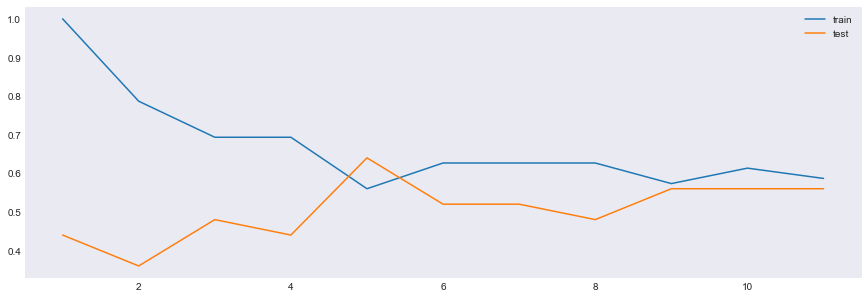

In [28]:
# plot the data
df_results.plot(kind="line", figsize=(15, 5))

## Business Analytics: Interpret the results

Discuss the results above, what do we think is going on? 

What should we use for a value of K?  

How accurate are we?